# Introductory Analysis w/ PGR-TK

Adapted code from `pgr-tk.ipynb`, https://github.com/GeneDx/pgr-tk, and https://genedx.github.io/pgr-tk/

`data` directory containing analysis located at `/storage/wwford/pgr-tk-test/data` on snorlax

In this notebook I use PGR-TK to visualize several structurally variable genes listed below.
* C4
* HTT
* CEL
* INS
* PRDM9

## Preprocess Pangenome

### Set up environment

In [2]:
%%bash
#conda install -c bioconda -c conda-forge python_abi libstdcxx-ng=12 libclang13 pgr-tk=0.3.6

In [2]:
from pathlib import Path
import pgrtk, os
print(pgrtk.__version__)

import matplotlib.pyplot as plt

pgrtk 0.3.6 (bioconda release build, linux [x86_64] [rustc 1.69.0 (84c898d65 2023-04-16)])


### Generate pgr-tk database through pgr-mdb. 

It takes as input a file containing the filepath to your AGC Pangenome file and a prefix for the resulting mdb and midx files. It takes about 45 min. The resulting files must be saved in the same location as the .agc input.

In [3]:
%%bash
#pgr-mdb filelist data/HPRC-yr1

Load midx into python. Takes about 70 seconds.

In [4]:
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/storage/wwford/pgr-tk-test/HPRC-yr1")

## Query individual regions

### Helper Functions

In [12]:
def load_sub_seq(loci:tuple, compliment=False, database=sdb) -> list:
    """ Reverse complement a sequence as a list of bytes (unsigned 8bit interger).

    Parameters
    ----------
    database    : loaded in .mdb object
    loci        : tuple containing ('genome_file', 'chromosome', start, end)
    compliment  : bool indicating whether the sequence should be complimented or not
    Returns
    -------
    list of bytes 
        the list of bytes of the given subsequence

    """
    subseq = database.get_sub_seq(loci[0], loci[1], loci[2], loci[3])
    if compliment: subseq = pgrtk.rc_byte_seq(subseq)
    return subseq

def plot_shimmer(seq:list, seq_name:str) -> None:
    """ 
    Plots shimmer overlaps of a sequence against itself. 
    x=y line indicates a sequence overlaps with itself. 
    Other lines indicates regions of regions of repeated sequence.

    Parameters
    ----------
    seq         : List containing bit representations of bases over a sequence
    seq_name    : Name for seq region

    Returns
    -------
    None

    """
    x, y = pgrtk.get_shmmr_dots(seq, seq, 32, 32, 2, 2)
    plt.figure(figsize=(5,5))
    plt.plot(x, y, ".", markersize=1)
    plt.title(f"{seq_name} vs {seq_name}")

def get_seq_list(ROI_seq: list, sdb=sdb, padding: int=1.5e5, plot=True) -> list:
    '''
    Get a list of sequences from sdb index that match the ROI_seq.
    :param sdb: SeqIndexDB object, the PGR index
    :param ROI_seq: ROI sequence
    :param padding: padding length  
    :param plot:  
    '''

    ROI_len = len(ROI_seq)

    # query the PGR index to find matches of this ROI
    query_results = pgrtk.query_sdb(sdb, ROI_seq, merge_range_tol=100000)
    seq_list = []
    seq_info = sdb.seq_info.copy() # Cache seq_info to reduce Rust HashMap to Python dictionary conversion in a loop
    i = 1
    if plot:
        plt.figure(figsize=(36, 36))
    for k in list(query_results.keys()):
        ctg_name, source, _ = seq_info[k]
        seq_id = k
        rgns = query_results[k].copy()
        # rgns = pgrtk.merge_regions(rgns,tol=1000) # if additional region merge needed
        for rgn in rgns:
            b, e, length, orientation, aln = rgn #beginning, end, length, orientation, alignments
            aln.sort()
            # Filters out reads that are not the entire length of the gene.
            #if aln[0][0][0] > padding or aln[-1][0][1] < padding + ROI_len: 
            #    continue
            
            seq =  sdb.get_sub_seq(source, ctg_name, b, e)
            # print(source, ctg_name, b, e)
            if orientation == 1:
                seq = pgrtk.rc_byte_seq(seq)

            seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
            
            if e-b < len(ROI_seq) * 0.50: # ignore partial match
                continue
            else:
                x, y = pgrtk.get_shmmr_dots(ROI_seq, seq, 32, 32, 1, 1)
                if i <= 25 and plot:
                    plt.subplot(5,5,i)
                    plt.plot(x, y, ".", markersize=0.1)
                    ylabel = "#".join(ctg_name.split("#")[:2])
                    if len(ylabel) > 20:
                        ylabel = ylabel[:20]
                    plt.ylabel(ylabel)
                    # plt.plot([padding, padding],[0, max(y)], "r")
                    # plt.plot([padding+ROI_len, padding+ROI_len],[0, max(y)], "r")
                i += 1

    return seq_list


### Collect Subsequences

These subsequence ranges are pulled from the NIH website. We have to use the T2T assembly ranges because HG38 isn't a single haplotype included in the HPRC Assembly.

In [20]:
# Assign Subsequences
# (Genome File Name, Chromosome Name, Seq Start Location, Seq End Location)
C4 = ('CHM13Y','chr6', 31835263, 31855887)
HTT = ('CHM13Y','chr4', 3073408, 3242718)
CEL = ('CHM13Y','chr9', 145276137, 145285985)
INS = ('CHM13Y','chr11', 2247427, 2248857)
PRDM9 = ('CHM13Y','chr5', 23614868,23635807)

In [7]:
C4_seq = load_sub_seq(C4)
HTT_seq = load_sub_seq(HTT)
CEL_seq = load_sub_seq(CEL)
INS_seq = load_sub_seq(INS)
PRDM9_seq = load_sub_seq(PRDM9)

### Verify Sequences

These sequences are pulled from the CHM13Y haploid from the T2T project from inside the PanGenome Year 1 dataset. The sequence ranges were pulled from the NIH website

In [8]:
C4 = pgrtk.u8_to_string(C4_seq)
HTT = pgrtk.u8_to_string(HTT_seq)
CEL = pgrtk.u8_to_string(CEL_seq)
INS = pgrtk.u8_to_string(INS_seq)
PRDM9 = pgrtk.u8_to_string(PRDM9_seq)

### Visualize Shimmer Self-overlaps

Shimmers plots are a method of depicting sequence overlap. When plotted against itself, highly repetitive regions should create orthogonal lines through the diagonal line through the origin.

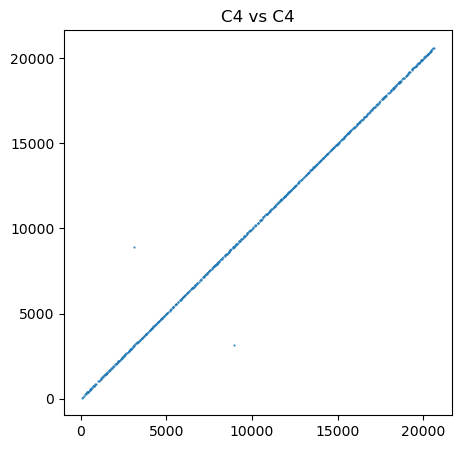

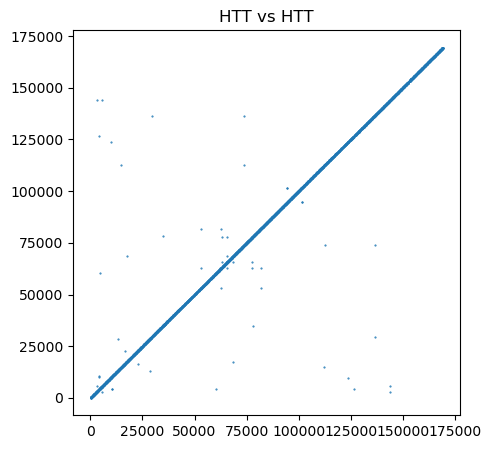

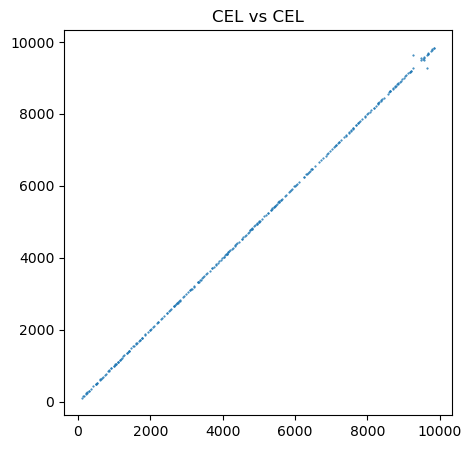

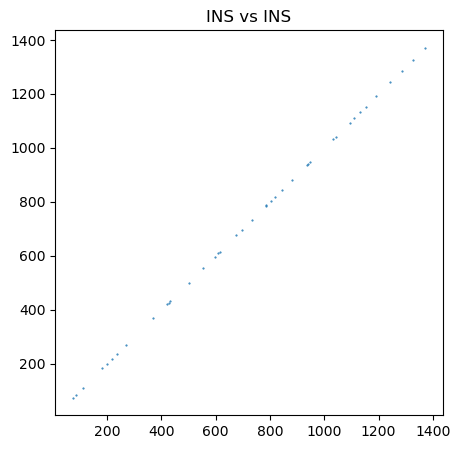

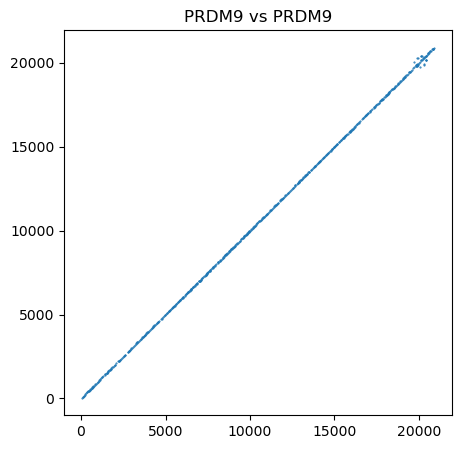

In [9]:
interesting_seqs = [C4_seq, HTT_seq, CEL_seq, INS_seq,PRDM9_seq]
seq_names = ["C4","HTT","CEL","INS","PRDM9"]
for seq, seq_name in zip(interesting_seqs, seq_names):
    plot_shimmer(seq, seq_name)

These have way less repeating regions than what I would expect. Likely the actual repetitive regions are a small subset of the larger gene ranges from NIH.

### Get hits from pangenome reference

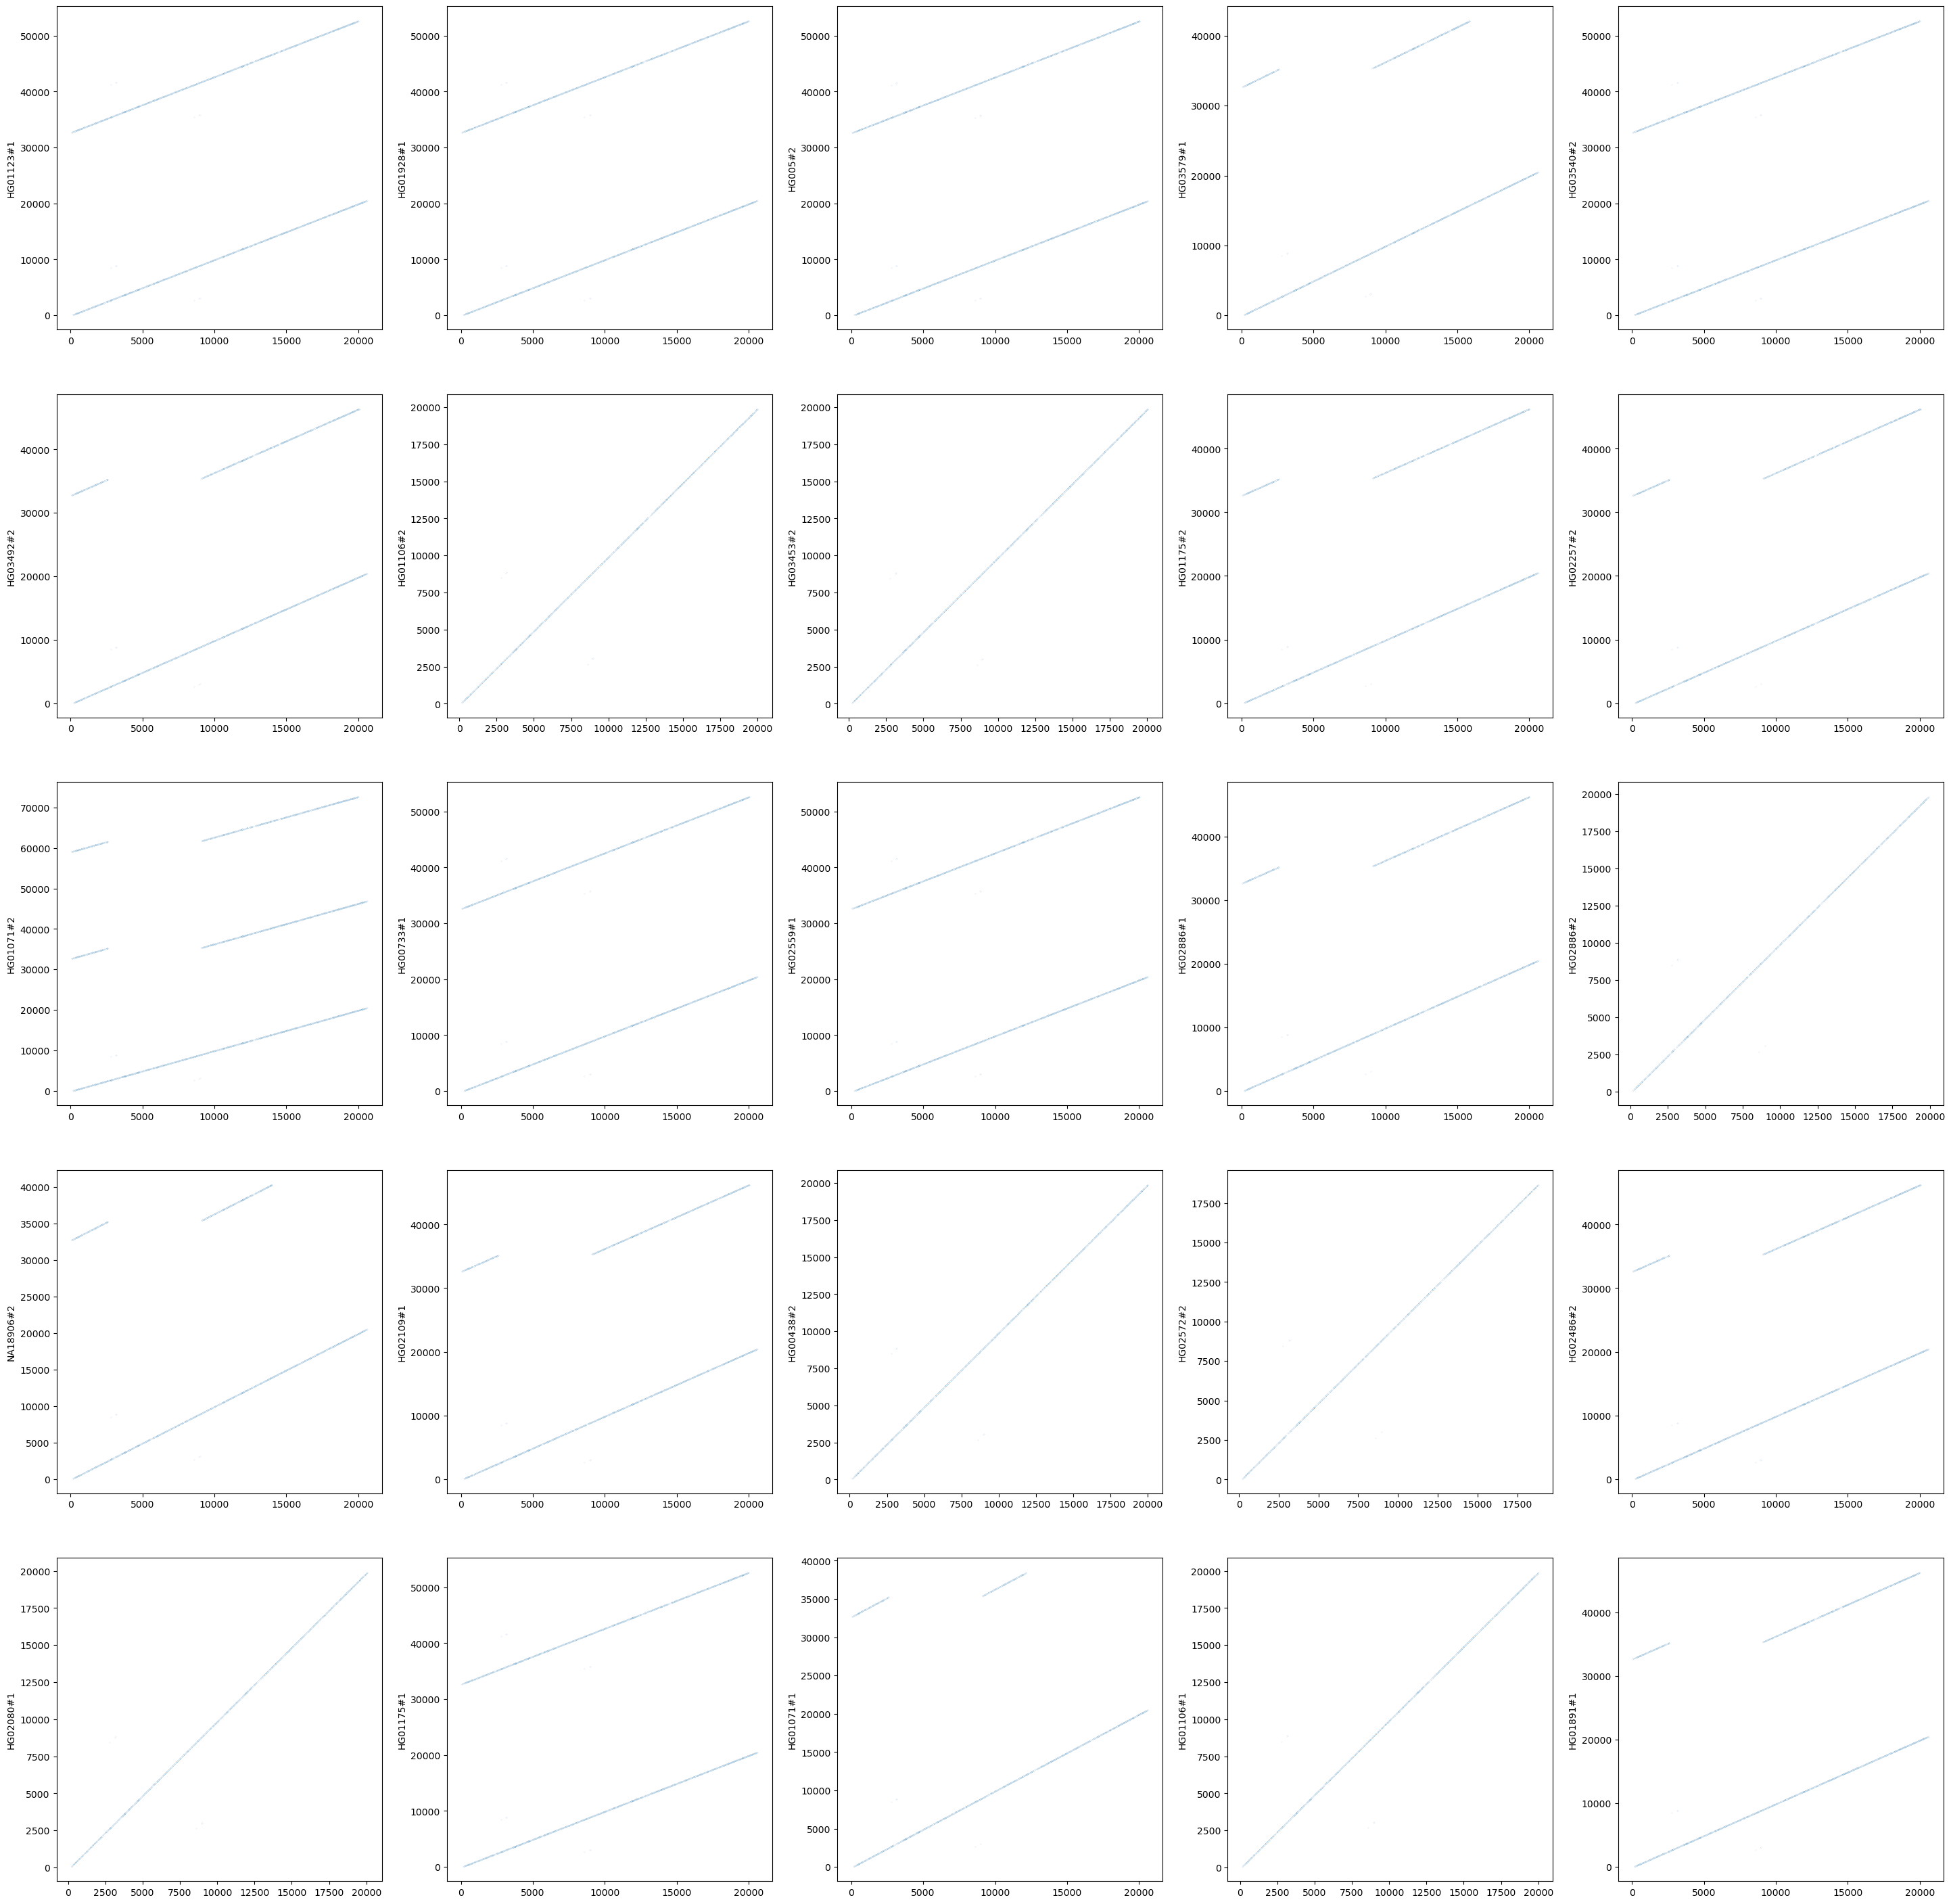

In [10]:
C4_list = get_seq_list(C4_seq, plot=True) # Plots show overlaps of individual assemblies with sequence.
HTT_list = get_seq_list(HTT_seq, plot=False)
CEL_list = get_seq_list(CEL_seq, plot=False)
INS_list = get_seq_list(INS_seq, plot=False)
PRDM9_list = get_seq_list(PRDM9_seq, plot=False) 

In [14]:
# INS has way less matches. 

ROI_lists = [C4_list, HTT_list, CEL_list, INS_list, PRDM9_list]
for l in ROI_lists:
    print(len(l))

95
95
95
29
95


### Build Subsets of Pangenome Graph

In [15]:
%%bash
#mkdir data
#mkdir data/region_graphs
#mkdir data/figures

In [16]:
ROI_lists = [C4_list, HTT_list, CEL_list, INS_list, PRDM9_list]

for seq_name, ROI_list in zip(seq_names, ROI_lists):
    new_sdb = pgrtk.SeqIndexDB()
    
    new_sdb.load_from_seq_list(ROI_list, w=80, k=56, r=12, min_span=18)
    '''
    w: window size, 1 minimizer per window, increase to analyze larger structures more 
        efficiently. 
    k: minimizer size, (should stay smaller than window size)
    r: hierarchical reduction factor, 
    min_span: Minimum distance between minimizers.
    '''
    new_sdb.generate_mapg_gfa(0, f"data/region_graphs/{seq_name}.gfa")

### Visualize Pangenome Graphs

In [17]:
%%bash
input="data/region_graphs/"
output="figures/"
for graph in $(ls data/region_graphs) ; do 
    image=${graph/".gfa"/".png"}
    echo "$output""$image"  
    Bandage image "$input""$graph" "$output""$image"  --edgewidth 1.0 --edgecol blue --colour random --outline 0.5 
    done

data/figures/C4.png
data/figures/C4_thresh50.png
data/figures/CEL.png
data/figures/CEL_thresh50.png
data/figures/HTT.png
data/figures/HTT_thresh50.png
data/figures/INS.png



Bandage error: could not load data/region_graphs/INS.gfa


data/figures/INS_thresh50.png



Bandage error: could not load data/region_graphs/INS_thresh50.gfa


data/figures/PRDM9.png
data/figures/PRDM9_thresh50.png


C4 Locus

![C4_locus](figures/C4.png) 

CEL Locus

![CEL_locus](figures/CEL.png)

HTT Locus

![HTT_locus](figures/HTT.png)

INS Locus

INS seq list has only 29 sequences to construct a graph while every other loci has 95 sequences. This indicates something about the INS region inside the T2T reference is too different from the other genomes for most of them to correctly grab the same region.

This difference in number of sequences though is not why the INS .gfa and graph is not generating as when we limit the other loci to only 29 sequences, they all produce graphs that are superfically similar to the fully informed graphs.

Then I believe the INS seq matches accross the non T2T assemblies are too different from each other to correctly form a graph. Even when relaxing parameters I couldn't get a graph to construct.

![INS_locus](figures/INS.png)

PRDM9 Locus

![PRDM9_locus](figures/PRDM9.png) 